## Load Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import pickle
import struct
import os
import random

import tensair_aux as tensair
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, Layer
from tensorflow.keras.models import Model

# Load input data
#Download Dataset from https://www.kaggle.com/code/anamkhan001/khan-airline-delay#ML-Model-Training-and-Validation
dataset_path = ""
df = pd.read_csv(dataset_path)

2025-06-27 15:40:33.744654: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 15:40:33.758356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/su_dalle-lucca-tosi/libtensorflow/lib
2025-06-27 15:40:33.758383: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Data Cleaning
* Missing cells
* Incorrect data types
* Duplicate rows
* etc.

In [3]:
# Figure out the percentage of missing cells to total cells
missing = df[df.isnull().any(axis=1)]
missing_sum = df.isnull().sum()
total_missing = missing_sum.sum()
total_cells = np.prod(df.shape)
percent_cells_missing = (total_missing/total_cells) * 100
print("Percent Missing: ", percent_cells_missing)

# Figure out how many % of rows are removed
df_dropped = df.dropna()
percent_rows_dropped = ( df_dropped.shape[0] / df.shape[0] ) * 100
print("Percent of original df after rows dropped: ", percent_rows_dropped)

# Does the dropped data effect specific carriers more than others?
old_carriers = df.carrier_name.value_counts()
new_carriers = df_dropped.carrier_name.value_counts()
percent_change_carriers =  ( (old_carriers - new_carriers) / old_carriers ) * 100

# Does the dropped data effect specific airports more than others?
old_airports = df.airport_name.value_counts()
new_airports = df_dropped.airport_name.value_counts()
percent_change_airports =  ( (old_airports - new_airports) / old_airports ) * 100
percent_change_airports = percent_change_airports[percent_change_airports > 1]
print("Airport with most change: ", percent_change_airports.idxmax())
print("Airport change percentage: ", percent_change_airports.max())


Percent Missing:  0.10549278138666834
Percent of original df after rows dropped:  99.74194074540095
Airport with most change:  Mobile, AL: Mobile Downtown
Airport change percentage:  8.333333333333332


In [4]:
# Worst is for Mobile (AL), a 8.5% drop, I think it's ok
df = df_dropped

# More Data Cleaning - Duplicate rows?
dupes = df.duplicated().sum()
print("Duplicated rows: ", dupes) # None, so good to move on

# More Data Cleaning - set up dates in correct time format
df['combined_date'] = pd.to_datetime(df['month'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y') 
df = df.drop(['month', 'year'], axis=1)
df = df[['combined_date'] + [col for col in df.columns if col != 'combined_date']]
df['Year'] = df['combined_date'].dt.year
df['Month'] = df['combined_date'].dt.month

Duplicated rows:  0


## Shape Data

In [7]:
categorical_cols = ['carrier', 'airport', 'Month']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

numerical_cols = ['arr_flights']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

target_col = 'arr_del15'


In [8]:
import numpy as np
import tensorflow as tf
# Optionally sort chronologically first
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Define the sizes
n = len(df)
train_end = int(0.4 * n)
val_end = int(0.4 * n)

# Slicing (chronological order)
train_df = df.iloc[:train_end].sample(frac=1, random_state=42).reset_index(drop=True)  # shuffled
val_df = df.iloc[train_end:val_end].reset_index(drop=True)  # in order
test_df = df.iloc[val_end:].reset_index(drop=True)  # in order

# Convert train dict to positional list of tensors
x_train = [
    train_df['carrier'].values.reshape(-1, 1),
    train_df['airport'].values.reshape(-1, 1),
    train_df['Month'].values.reshape(-1, 1),
    train_df[numerical_cols].values
]

# Convert val dict to positional list
x_val = [
    val_df['carrier'].values.reshape(-1, 1),
    val_df['airport'].values.reshape(-1, 1),
    val_df['Month'].values.reshape(-1, 1),
    val_df[numerical_cols].values
]

x_test = [
    test_df['carrier'].values.reshape(-1, 1),
    test_df['airport'].values.reshape(-1, 1),
    test_df['Month'].values.reshape(-1, 1),
    test_df[numerical_cols].values
]

# Target values
y_train = train_df[target_col].values
y_val = val_df[target_col].values
y_test = test_df[target_col].values

### Save Test

In [9]:
save_folder_path=""
with open(save_folder_path+'test_data.pickle', 'wb') as handle:
    pickle.dump((x_test,y_test), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open(save_folder_path+"test_data.bin", "wb") as f:
    for carrier, airport, month, numerical, label in zip(x_test[0],x_test[1],x_test[2],x_test[3], y_test):
        # Pack and write all 5 values: 3 ints, 2 floats
        f.write(struct.pack('<iii ff', carrier[0], airport[0], month[0], numerical, label))

## Create Model

In [11]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))


In [12]:
class FlightDelay(tensair.TensAIR):
    def __init__(self, categorical_inputs_info, num_numerical_features, 
                 embed_dim=32, num_heads=4, ff_dim=128, dropout_rate=0.1):
        super(FlightDelay, self).__init__()

        self.num_categorical_inputs = len(categorical_inputs_info)
        self.num_numerical_features = num_numerical_features

        # List of embedding layers
        self.embeddings = [
            Embedding(input_dim=vocab_size, output_dim=embed_dim, name=f"cat{i}_embedding")
            for i, vocab_size in enumerate(categorical_inputs_info.values())
        ]

        self.transformer = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)
        self.flatten = Flatten()
        self.concat = Concatenate()

        self.dense1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(32, activation='relu')
        self.output_layer = Dense(1)

    @tf.function
    def call(self, inputs, training=False):
        cat_embeds = []
        for i in range(self.num_categorical_inputs):
            x_cat = inputs[i]  # shape: (batch, 1)
            x_emb = tf.squeeze(self.embeddings[i](x_cat), axis=1)  # shape: (batch, embed_dim)
            cat_embeds.append(x_emb)
    
        # Stack embeddings into sequence for transformer
        x_cat = tf.stack(cat_embeds, axis=1)  # shape: (batch, num_cat, embed_dim)
        x_transformed = self.transformer(x_cat, training=training)
        x_transformed = self.flatten(x_transformed)
    
        # Numerical input
        x_num = inputs[-1]  # shape: (batch, num_numerical_features)
        x = self.concat([x_transformed, x_num])
    
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        return self.output_layer(x)


In [15]:
from tensorflow.keras.optimizers import Adam, SGD
# Define input info
categorical_inputs_info = {
    'carrier': df['carrier'].nunique(),
    'airport': df['airport'].nunique(),
    'month': 12
}
num_numerical_features = len(numerical_cols)

# Instantiate and compile the model
model = FlightDelay(categorical_inputs_info, num_numerical_features=num_numerical_features)
model.compile(optimizer=SGD(learning_rate=0.005), loss='mae', metrics=['mae'])

# Fit model
model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=15,
    batch_size=32
)


Epoch 1/15
2141/2141 [==============================] - 9s 4ms/step - loss: 32.6788 - mae: 32.6788
Epoch 2/15
2141/2141 [==============================] - 9s 4ms/step - loss: 21.8104 - mae: 21.8104
Epoch 3/15
2141/2141 [==============================] - 8s 4ms/step - loss: 20.7483 - mae: 20.7483
Epoch 4/15
2141/2141 [==============================] - 8s 4ms/step - loss: 20.4449 - mae: 20.4449
Epoch 5/15
2141/2141 [==============================] - 9s 4ms/step - loss: 19.9136 - mae: 19.9136
Epoch 6/15
2141/2141 [==============================] - 9s 4ms/step - loss: 19.7089 - mae: 19.7089
Epoch 7/15
2141/2141 [==============================] - 8s 4ms/step - loss: 19.3305 - mae: 19.3305
Epoch 8/15
2141/2141 [==============================] - 9s 4ms/step - loss: 19.2786 - mae: 19.2786
Epoch 9/15
2141/2141 [==============================] - 9s 4ms/step - loss: 19.1404 - mae: 19.1404
Epoch 10/15
2141/2141 [==============================] - 9s 4ms/step - loss: 19.0339 - mae: 19.0339
Epoch 11/

3211/3211 [==============================] - 8s 2ms/step


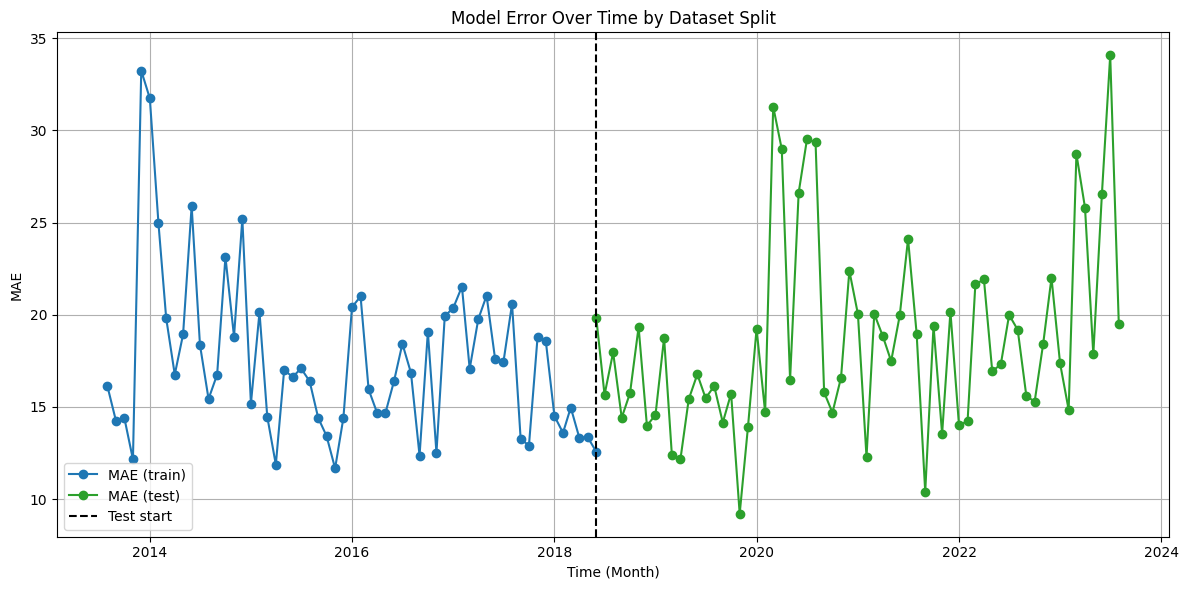

In [16]:
# Helper to compute loss per month for a given set
def compute_monthly_loss(df, y_true, y_pred, label):
    df = df.copy()
    df['y_true'] = y_true
    df['y_pred'] = y_pred
    df['abs_error'] = abs(df['y_true'] - df['y_pred'])
    df['squared_error'] = (df['y_true'] - df['y_pred']) ** 2

    # Group by month and compute losses
    grouped = df.groupby('combined_date').agg(
        mae=('abs_error', 'mean'),
        rmse=('squared_error', lambda x: mean_squared_error(
            df.loc[x.index, 'y_true'], df.loc[x.index, 'y_pred'], squared=False))
    ).reset_index()

    grouped['split'] = label
    return grouped

# Predict
y_train_pred = model.predict(x_train).flatten()  # flatten if shape (n,1)
y_test_pred = model.predict(x_test).flatten()  # flatten if shape (n,1)

# Compute error metrics over time
train_loss = compute_monthly_loss(train_df, y_train, y_train_pred, 'train')
test_loss = compute_monthly_loss(test_df, y_test, y_test_pred, 'test')

full_loss = pd.concat([train_loss, test_loss]).sort_values(by='combined_date').reset_index(drop=True)


# Plot
plt.figure(figsize=(12, 6))
#for split, color in zip(['train', 'val', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
for split, color in zip(['train', 'test'], ['tab:blue', 'tab:green']):
    subset = full_loss[full_loss['split'] == split]
    plt.plot(subset['combined_date'], subset['mae'], label=f'MAE ({split})', marker='o', color=color)

# Vertical lines to indicate segment transitions
test_start_date = test_loss['combined_date'].min()
plt.axvline(test_start_date, color='black', linestyle='--', label='Test start')

plt.xlabel('Time (Month)')
plt.ylabel('MAE')
plt.title('Model Error Over Time by Dataset Split')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Save TensAIR model

In [17]:
# Create training data using positional inputs
x1 = tf.zeros((3,1), dtype=tf.dtypes.int32)
x2 = tf.zeros((3,1), dtype=tf.dtypes.int32)
x3 = tf.zeros((3,1), dtype=tf.dtypes.int32)
x4 = tf.zeros((3,1), dtype=tf.dtypes.float32)

model.predict((x1, x2, x3, x4))


1/1 [==============================] - 0s 178ms/step


array([[59.630962],
       [59.630962],
       [59.630962]], dtype=float32)

In [18]:
model.init_delta(model.trainable_weights)

In [19]:
input_tensors_dims = [[None,1],[None,1],[None,1],[None,1],[None,1]]
input_tensors_types = [tf.int32,tf.int32,tf.int32,tf.float32,tf.float32]
input_tensors_structure = ((1,1,1,1),1)

In [20]:
signatures = tensair.define_signatures(model, input_tensors_dims,input_tensors_types,input_tensors_structure)

/home/su_dalle-lucca-tosi/.pyenv/versions/3.8.0/envs/tensair2/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("PartitionedCall:1", shape=(None, 32), dtype=float32), dense_shape=Tensor("PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/su_dalle-lucca-tosi/.pyenv/versions/3.8.0/envs/tensair2/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:5", shape=(None,), dtype=int32), values=Tensor("PartitionedCall:4", shape=(None, 32), dtype=float32), dense_shape=Tensor("PartitionedCall:6", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/

In [ ]:
save_folder=""
model.save(save_folder+'model', save_format="tf", signatures=signatures)

## Compare TensAIR

### Run TensAIR in terminal before executing the following cells

Before executing the following cells, please run the TensAIR experiment on terminal. Upon stop of the training (all data samples of the dataset have been used), you may compare TensAIR results with the ones from TensorFlow.

In [22]:
y_test_pred = model.predict(x_test).flatten()

3211/3211 [==============================] - 8s 2ms/step


In [23]:
tensorflow_error = abs(y_test - y_test_pred)

In [36]:
import csv
tensair_error = []
current_status = "training"
status = ['0- training']
count = 0
results_path=""
with open(results_path+'0.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        count += 1
        if row[0] != current_status:
            current_status = row[0]
            status.append(str(count)+"- " +row[0])
        tensair_error.append([float(row[2]), current_status])


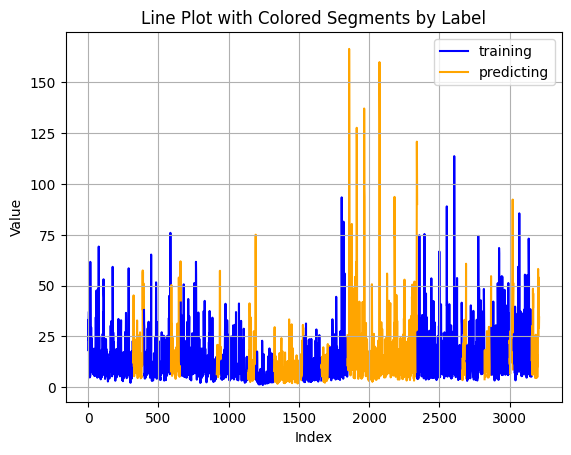

In [37]:
import matplotlib.pyplot as plt

# Color mapping
label_to_color = {
    'training': 'blue',
    'predicting': 'orange'
}

# Prepare to collect segments
segments = []
current_segment = {'x': [], 'y': [], 'label': tensair_error[0][1]}

for i, (value, label) in enumerate(tensair_error):
    if label == current_segment['label']:
        current_segment['x'].append(i)
        current_segment['y'].append(value)
    else:
        segments.append(current_segment)
        current_segment = {'x': [i], 'y': [value], 'label': label}

# Append the last segment
segments.append(current_segment)

# Plot each segment with its label color
for segment in segments:
    plt.plot(segment['x'], segment['y'], color=label_to_color[segment['label']], label=segment['label'], zorder=1)



# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Plot with Colored Segments by Label")
plt.grid(True)
plt.show()


In [38]:
# Ensure datetime
test_df['combined_date'] = pd.to_datetime(test_df['combined_date'])
test_df2 = test_df.copy(deep=True)
test_df2 = test_df2.iloc[:-14]

# Assume each entry represents an average of 32 records
batch_size = 32

# Expand segment values and labels
expanded_segment_values = np.repeat([v for v, _ in tensair_error], batch_size)
expanded_segment_labels = np.repeat([label for _, label in tensair_error], batch_size)

# Add errors to the DataFrame
test_df2['tensair_error'] = expanded_segment_values
test_df2['tensair_label'] = expanded_segment_labels
test_df2['tensorflow_error'] = tensorflow_error[:-14]

# Add a 'month' column for grouping
test_df2['month'] = test_df2['combined_date'].dt.to_period('M')


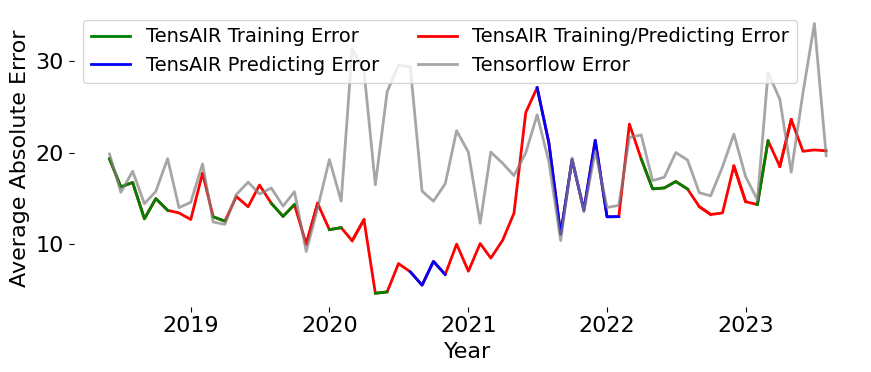

In [70]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 16,         # base font size
    'axes.titlesize': 16,    # title
    'axes.labelsize': 16,    # x and y labels
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})


# Step 1: Aggregate sums and counts for weighted average
agg = test_df2.groupby(['month', 'tensair_label'])['tensair_error'].agg(['sum', 'count', 'mean']).unstack()

# Step 2: Create the base DataFrame with all columns
training_mean = agg['mean'].get('training')
predicting_mean = agg['mean'].get('predicting')

training_sum = agg['sum'].get('training').fillna(0)
predicting_sum = agg['sum'].get('predicting').fillna(0)
training_count = agg['count'].get('training').fillna(0)
predicting_count = agg['count'].get('predicting').fillna(0)

# Step 3: Compute total weighted average
total_sum = training_sum + predicting_sum
total_count = training_count + predicting_count
weighted_avg = total_sum / total_count
weighted_avg[total_count == 0] = np.nan  # guard against divide-by-zero

# Step 4: Identify which months have both labels
has_training = training_count > 0
has_predicting = predicting_count > 0
has_both = has_training & has_predicting
only_training = has_training & ~has_predicting
only_predicting = has_predicting & ~has_training

# Step 5: Construct final DataFrame
final_df = pd.DataFrame(index=agg.index)
final_df['training'] = training_mean.where(only_training)
final_df['predicting'] = predicting_mean.where(only_predicting)
final_df['both'] = weighted_avg.where(has_both)
final_df['tensorflow'] = test_df2.groupby(['month'])['tensorflow_error'].agg(['mean'])

# Merge training, predicting, and both into one continuous line (prioritized in this order)
merged_error = final_df['training'].combine_first(final_df['predicting']).combine_first(final_df['both'])

plt.figure(figsize=(9, 4))

# Plot merged line from all three types
plt.plot(final_df.index.to_timestamp(), merged_error, color='red', linewidth=2)

# Plot individual segment lines as dotted for reference (optional)
plt.plot(final_df.index.to_timestamp(), final_df['training'], label='TensAIR Training Error', color='green', linewidth=2)
plt.plot(final_df.index.to_timestamp(), final_df['predicting'], label='TensAIR Predicting Error', color='blue', linewidth=2)
plt.plot(final_df.index.to_timestamp(), final_df['both'], label='TensAIR Training/Predicting Error', color='red', linewidth=2)

# Plot tensorflow error
plt.plot(final_df.index.to_timestamp(), final_df['tensorflow'], label='Tensorflow Error', color='grey', alpha=0.7, linewidth=2)

ax = plt.gca()  # Get current axes

# Hide all four spines (borders)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)



plt.xlabel('Year')
plt.ylabel('Average Absolute Error')
#plt.title('Online Flight Delay Prediction')
plt.legend(ncol=2)
plt.grid(False)
plt.tight_layout()
image_path=""
plt.savefig(image_path+'results.png')

plt.show()

In [40]:
save_path=""
with open(save_path+ 'results2.pickle', 'wb') as handle:
    pickle.dump(final_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
training_count = 0
predicting_count = 0
for e in tensair_error:
    if e[1] == 'training':
        training_count += 1
    else:
        predicting_count+= 1

In [45]:
training_count

2049

In [46]:
predicting_count

1161